In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Imports
import numpy as np
import os
import sys
import pennylane as qml
from pennylane import numpy as pnp
import torch
import torch.nn as nn

## Imports
import os
import sys
import matplotlib

# matplotlib.use('Agg')  # Set the backend to Agg

import matplotlib.pyplot as plt
import h5py
import pandas as pd

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../"))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


# from src.utils.color import model_color
# from src.utils.plot_loss import plot_loss_history
from src.utils.logger import Logging
from src.utils.cavity_plot_contour import draw_contourf_regular_2D
from src.poisson.cv_solver import CVPDESolver
from src.poisson.dv_solver import DVPDESolver
from src.utils.error_metrics import lp_error

In [4]:
log_path = "../../testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate Testing Dataset


In [5]:
skip = 10
tstep = 101
xstep = 100
ystep = 100

TEST_DATA_PKL = "../../data/cavity.mat"  # Assuming this is the correct path
data = h5py.File(TEST_DATA_PKL, "r")  # load dataset from matlab

domain = pd.DataFrame(data["cavity_internal"]).T.to_numpy()

#  t = tf.reshape(tstep,N_data)[:,0].T
time_ = (
    domain[:, 0:1].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
)  # (101, 10, 10)
xfa = domain[:, 1:2].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
yfa = domain[:, 2:3].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
ufa = domain[:, 3:4].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
vfa = domain[:, 4:5].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
pfa = domain[:, 5:6].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)

In [6]:
new_shape = domain[:, 0:1].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].shape

# Load trained model


In [7]:
model_path = (
    "../../checkpoints/cavity/2025-01-19_22-57-12-521069/model.pth"  # sim_circ_13_half
)

In [1]:
solver = "CV"

if solver == "CV":
    state = CVPDESolver.load_state(model_path)
    state["args"]["method"] = "non_gaussian"
    model = CVPDESolver(state["args"], logger, data, DEVICE, ntype="two")

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])
else:
    state = DVPDESolver.load_state(model_path)
    model = DVPDESolver(state["args"], logger, data, DEVICE, ntype="two")
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])

model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : , {len(state['loss_history'])}")
model.logger.print(f"The final loss : , {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")

NameError: name 'CVPDESolver' is not defined

## Prediction Results


In [10]:
test_torch_data = torch.tensor(
    np.concatenate([time_, xfa, yfa], axis=1), dtype=torch.float32
).to(model.device)
with torch.no_grad():
    predictions = model.forward(test_torch_data)
if predictions.is_cuda:
    predictions = predictions.cpu()
u_pred = predictions[:, 0:1].numpy()
v_pred = predictions[:, 1:2].numpy()
p_pred = predictions[:, 2:3].numpy()

In [21]:
text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred, ufa, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred, vfa, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred, pfa, (text + "P%"), logger, 2)

logger.print("Final loss %e" % (model.loss_history[-1]))

logger.print("******************************\n")

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:RelL2_U%  : 7.973e+01 
INFO:src.utils.logger:RelL2_V%  : 1.001e+02 
INFO:src.utils.logger:RelL2_P%  : 8.482e+01 
INFO:src.utils.logger:Final loss 2.588607e-01
INFO:src.utils.logger:******************************

INFO:src.utils.logger:file directory:
INFO:src.utils.logger:../../testing_checkpoints/2025-01-26_11-24-00-048205


In [12]:
# INFO:src.utils.logger:RelL2_U%  : 7.653e+01
# INFO:src.utils.logger:RelL2_V%  : 9.943e+01
# INFO:src.utils.logger:RelL2_P%  : 8.247e+01
# INFO:src.utils.logger:Final loss 2.454881e-01
# INFO:src.utils.logger:******************************

# INFO:src.utils.logger:file directory:
# INFO:src.utils.logger:../../testing_checkpoints/2025-01-25_14-58-53-776945

In [13]:
tstep = new_shape[0]
xstep = new_shape[1]
ystep = new_shape[2]

txy = [xfa, yfa, time_]
steps = [tstep, xstep, ystep]

#  t = tf.reshape(tstep,N_data)[:,0].T
tf = time_.reshape(tstep, xstep, ystep)
xf = xfa.reshape(tstep, xstep, ystep)
yf = yfa.reshape(tstep, xstep, ystep)


exact_u = ufa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_v = vfa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_p = pfa.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]

u_pred_tanh = u_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
v_pred_tanh = v_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
p_pred_tanh = p_pred.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]

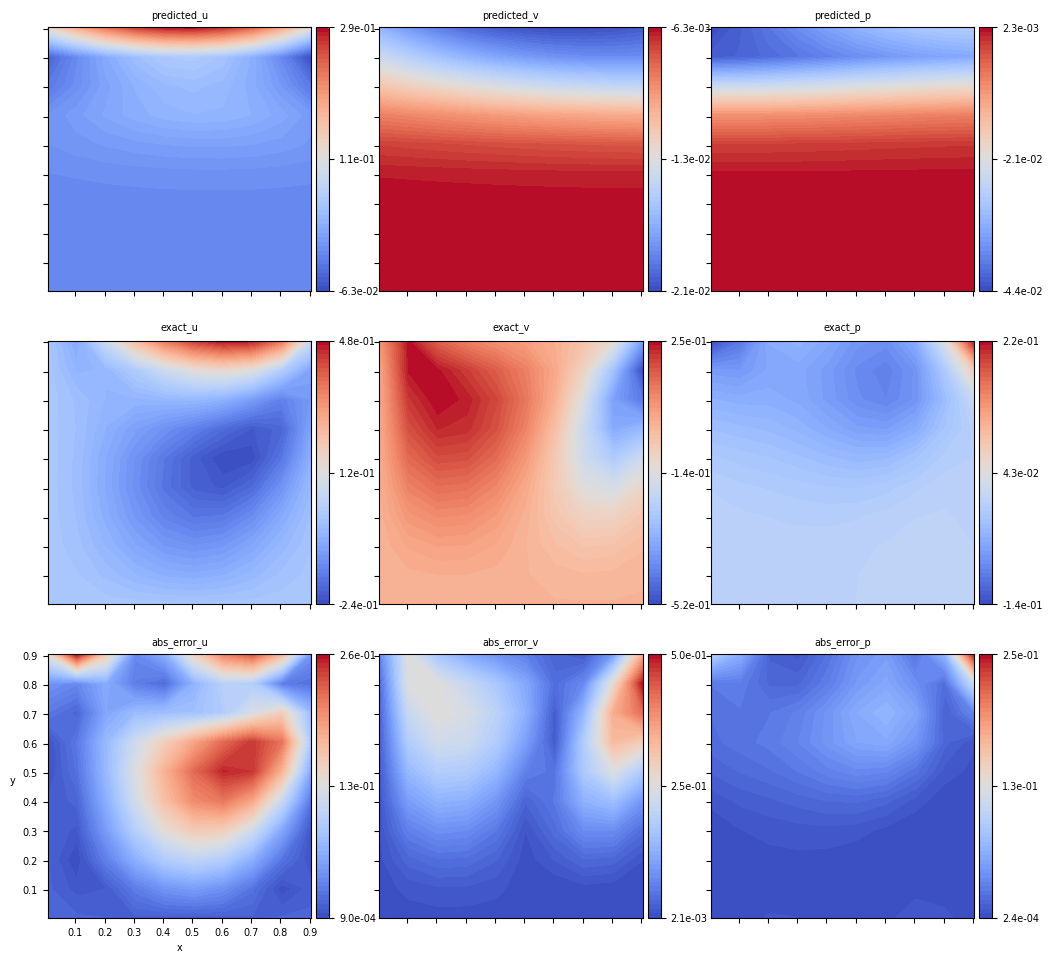

In [14]:
tanh_error_u = np.abs(u_pred_tanh - exact_u)
tanh_error_v = np.abs(v_pred_tanh - exact_v)
tanh_error_p = np.abs(p_pred_tanh - exact_p)

data = [
    u_pred_tanh,
    v_pred_tanh,
    p_pred_tanh,
    exact_u,
    exact_v,
    exact_p,
    tanh_error_u,
    tanh_error_v,
    tanh_error_p,
]

titles = [
    "predicted_u",
    "predicted_v",
    "predicted_p",
    "exact_u",
    "exact_v",
    "exact_p",
    "abs_error_u",
    "abs_error_v",
    "abs_error_p",
]

plot_xy = False

time_steps = [0, 99]
xy_labels = [r"$x→$", r"$y→$"]

x = xf[0, :, :][..., None]
y = yf[0, :, :][..., None]
nrows_ncols = (3, 3)
values = [99]
xref = 1
yref = 1
model_dirname = model.log_path
img_width = 10
img_height = 10
ticks = 3
fontsize = 7
labelsize = 7
axes_pad = 0.5
X = np.concatenate([x, y], axis=-1)
# for time_step in time_steps:
#     for index, (title, z) in enumerate(zip(titles, data)):
#         file_name = os.path.join(model.log_path, f"{index}_{title}_time{time_step}.png")
#         plot_xy = index == 12
#         fig = plot_contour(X, z[time_step, :, :], file_name, plot_xy, xy_labels)

draw_contourf_regular_2D(
    tf[:, 0, 0],
    xf[0, 0, :],
    yf[0, :, 0],
    data,
    titles,
    nrows_ncols,
    values,
    xref,
    yref,
    model_dirname,
    img_width,
    img_height,
    ticks,
    fontsize,
    labelsize,
    axes_pad,
)

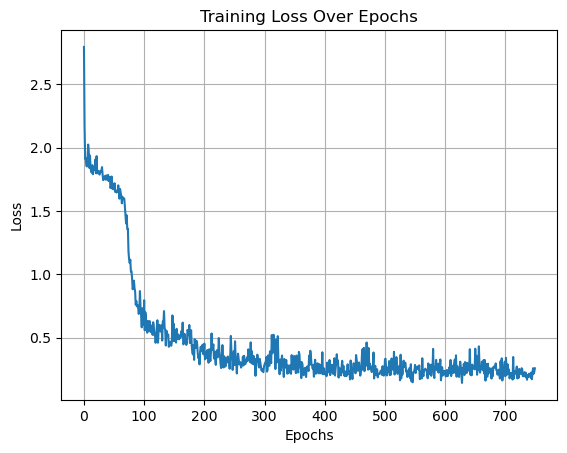

In [22]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

In [16]:
# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 857
